In [29]:
import gc # garbage collection
import re # regulates expressions/strings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
import time

In [2]:
gc.collect() # removes unused/unneeded objects
trueNews = pd.read_csv('newsData/True.csv')
fakeNews = pd.read_csv('newsData/Fake.csv')

print("Preview of Fake News Articles:")
display(fakeNews.head())
print("Preview of True News Articles:")
display(trueNews.head())

Preview of Fake News Articles:


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Preview of True News Articles:


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
print(f"True News Dataset Shape: {trueNews.shape}")
print(f"Fake News Dataset Shape {fakeNews.shape}")

print("\nColumns in the Dataset:")
print(trueNews.columns)

print("\nMissing Values in True News:")
print(trueNews.isnull().sum().sum())

print("\nMissing Values in Fake News:")
print(fakeNews.isnull().sum().sum())


True News Dataset Shape: (21417, 4)
Fake News Dataset Shape (23481, 4)

Columns in the Dataset:
Index(['title', 'text', 'subject', 'date'], dtype='object')

Missing Values in True News:
0

Missing Values in Fake News:
0


In [4]:
print(trueNews.info())
print("\n", trueNews['subject'].value_counts())
print("\n", trueNews.nunique())
print("\n", f"Duplicated rows: {trueNews.duplicated().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None

 subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

 title      20826
text       21192
subject        2
date         716
dtype: int64

 Duplicated rows: 206


In [5]:
print(fakeNews.info())
print("\n", fakeNews['subject'].value_counts())
print("\n", fakeNews.nunique())
print("\n", f"Duplicated rows: {fakeNews.duplicated().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None

 subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

 title      17903
text       17455
subject        6
date        1681
dtype: int64

 Duplicated rows: 3


In [6]:
fakeNews = fakeNews[fakeNews['subject'].isin(['politics', 'News'])].copy() # filters data
subjectMapping = { # maps news subjects
    'politics': 'politicsNews',
    'News': 'worldnews'
}
fakeNews['subject'] = fakeNews['subject'].map(subjectMapping)

print("Subjects in fakeNews after cleaning:", fakeNews['subject'].unique())
print(f"Cleaned Fake News shape: {fakeNews.shape}")
print("Subjects i trueNews (already chosen):", trueNews['subject'].unique())

Subjects in fakeNews after cleaning: ['worldnews' 'politicsNews']
Cleaned Fake News shape: (15891, 4)
Subjects i trueNews (already chosen): ['politicsNews' 'worldnews']


In [7]:
# confirming consistency after cleaning

print("Subjects in trueNews:", trueNews['subject'].unique())
print("Subjects in fakeNews:", fakeNews['subject'].unique())

print("\nMissing subjects in trueNews:", trueNews['subject'].isnull().sum())
print("Missing subjects in fakeNews:", fakeNews['subject'].isnull().sum())

print(f"\nTrue News shape: {trueNews.shape}")
print(f"Fake News shape:', {fakeNews.shape}")

Subjects in trueNews: ['politicsNews' 'worldnews']
Subjects in fakeNews: ['worldnews' 'politicsNews']

Missing subjects in trueNews: 0
Missing subjects in fakeNews: 0

True News shape: (21417, 4)
Fake News shape:', (15891, 4)


note to self; for most deep learning cases, you'll want to use one-hot encoding 
* this is because it helps to avoid overfit and bias in the learning process
* the computer might assume label encoding is a stand-in for rankings

however, one-hot encoding would be considered overkill in this situation 
* specifically, it can increase memory usage
* so, instead i'll use label encoding (as 0s and 1s) for the subjects

In [8]:
# 1 = real news
# 0 = fake news 

fakeNews['labelAuthenticity'] = 0
trueNews['labelAuthenticity'] = 1

# 1 = worldnews
# 0 for politicsNews

subjectMapping = {
    'politicsNews': 0,
    'worldnews': 1
}

trueNews['labelSubject'] = trueNews['subject'].map(subjectMapping)
fakeNews['labelSubject'] = fakeNews['subject'].map(subjectMapping)

newsDF = pd.concat([trueNews, fakeNews], ignore_index = True)
print("Combined Dataset Shape:", newsDF.shape) # combined for ease of cleaning
display(newsDF.head())

# note ; ignore_index is NOT a user-made variable

Combined Dataset Shape: (37308, 6)


,title,text,subject,date,labelAuthenticity,labelSubject
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,0


In [9]:
# cleaning the data from uppercase, urls, and extra spaces

def cleanText(text):
    text = text.lower() # lowercase
    text = re.sub(r'http\S+|www\S+', '', text) # remove urls
    text = re.sub(r'<.*?>', '', text) # remove html
    text = re.sub(r'[^a-z\s]', '', text) # remove symbols
    text = re.sub(r'\s+', ' ', text) # remove extra space
    return text

newsDF['cleanText'] = newsDF['text'].apply(cleanText)
newsDF['cleanTitle'] = newsDF['title'].apply(cleanText)
display(newsDF[['title', 'cleanTitle', 'cleanText']].head())

# note; re.sub lists the pattern to replace, empty space, and then the saved text

,title,cleanTitle,cleanText
0,"As U.S. budget fight looms, Republicans flip t...",as us budget fight looms republicans flip thei...,washington reuters the head of a conservative ...
1,U.S. military to accept transgender recruits o...,us military to accept transgender recruits on ...,washington reuters transgender people will be ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,senior us republican senator let mr mueller do...,washington reuters the special counsel investi...
3,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped by australian diplomat...,washington reuters trump campaign adviser geor...
4,Trump wants Postal Service to charge 'much mor...,trump wants postal service to charge much more...,seattlewashington reuters president donald tru...


In [10]:
# finishing cleaning by removing the duplicate articles

before = newsDF.shape[0]
newsDF = newsDF.drop_duplicates(subset='cleanText').reset_index(drop = True)
after = newsDF.shape[0]

print(f"Removed {before - after} duplicate articles")
print(f"New dataset size: {after} rows")

Removed 716 duplicate articles
New dataset size: 36592 rows


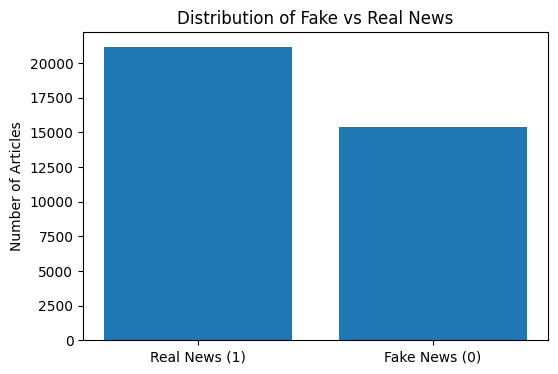

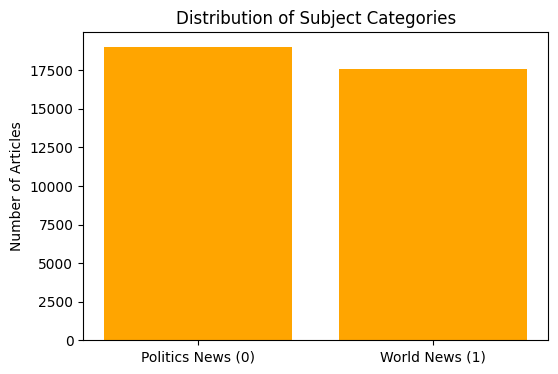

In [11]:
authCounts = newsDF['labelAuthenticity'].value_counts()
authLabels = ['Real News (1)', 'Fake News (0)']

plt.figure(figsize = (6, 4))
plt.bar(authLabels, authCounts)
plt.title("Distribution of Fake vs Real News")
plt.ylabel("Number of Articles")
plt.show()

subjectCounts = newsDF['labelSubject'].value_counts()
subjectLabels = ['Politics News (0)', 'World News (1)']

plt.figure(figsize = (6, 4))
plt.bar(subjectLabels, subjectCounts, color = 'Orange')
plt.title("Distribution of Subject Categories")
plt.ylabel("Number of Articles")
plt.show()

C:\Users\elian\AppData\Local\Temp\ipykernel_8432\1089107384.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  newsDF.strat, _ = train_test_split(newsDF, train_size = 2000, stratify = newsDF['labelAuthenticity'], random_state = 42)


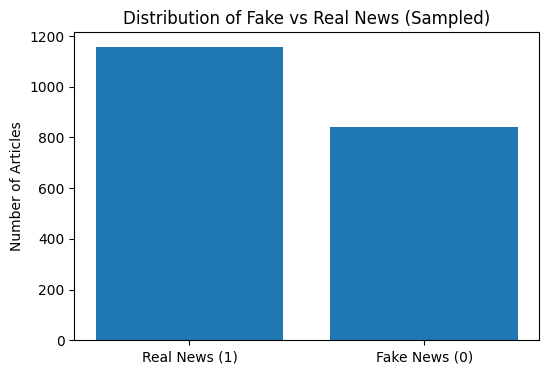

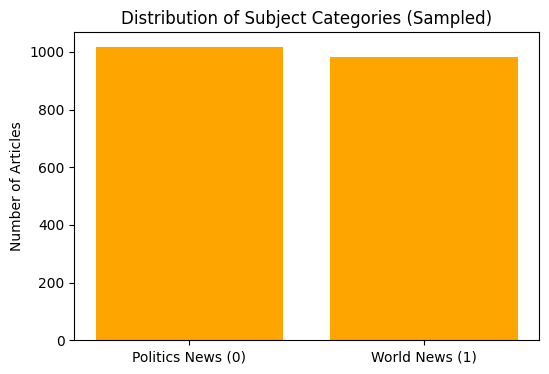

In [12]:
# takes a sample of 2000 articles without changing the class distribution
newsDF.strat, _ = train_test_split(newsDF, train_size = 2000, stratify = newsDF['labelAuthenticity'], random_state = 42)
newsDF = newsDF.strat.reset_index(drop = True)

authCounts = newsDF['labelAuthenticity'].value_counts()
authLabels = ['Real News (1)', 'Fake News (0)']

plt.figure(figsize = (6, 4))
plt.bar(authLabels, authCounts)
plt.title("Distribution of Fake vs Real News (Sampled)")
plt.ylabel("Number of Articles")

subjectCounts = newsDF['labelSubject'].value_counts()
subjectLabels = ['Politics News (0)', 'World News (1)']

plt.figure(figsize = (6, 4))
plt.bar(subjectLabels, subjectCounts, color = 'Orange')
plt.title("Distribution of Subject Categories (Sampled)")
plt.ylabel("Number of Articles")
plt.show()

In [13]:
newsDF['combinedText'] = newsDF['cleanTitle'] + "[SEP]" + newsDF['cleanText']
newsDF.sample(5)

sampleIDX = 42
print("Combined Text:")
print(newsDF['combinedText'].iloc[sampleIDX])
print("Authenticity Label:", newsDF['labelAuthenticity'].iloc[sampleIDX])
print("Subject label:", newsDF['labelSubject'].iloc[sampleIDX])

Combined Text:
 muslim migrants gang rape yr old girlmuslim lawyer blames girl[SEP]tell us again barack about the poor widows and orphans who are being strategically placed in our small towns and communities across america with all the rape and violence being committed by these refugees why in the world would we welcome these savage animals into our country oh that s right to vote for democrats a muslim councilor has admitted that some feel as though it takes two to tango as men were jailed for gangraping a yearold white girl in west yorkshirethe gang of men from pakistani origin were jailed for a total of years at bradford crown court today for months of horrendous abuse of the british white girl in and however the councillor for keighley central where the abuse took place has admitted that some members of the community felt it takes two to tango and that the girl may have played her part zafar ali who has been a member of the keighley mosque for decades believes that some of the men 

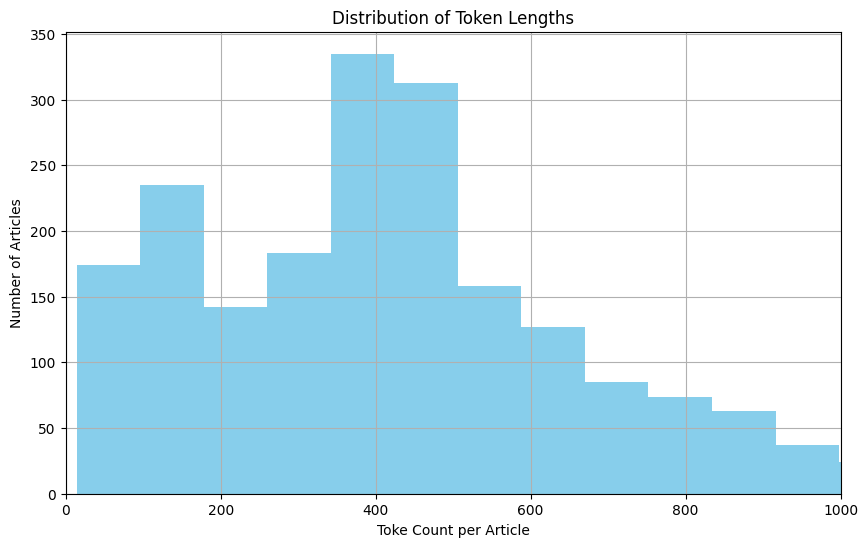

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenLengths = [len(tokenizer.tokenize(text)) for text in newsDF['combinedText']]

plt.figure(figsize = (10, 6))
plt.hist(tokenLengths, bins = 50, color = 'skyblue')
plt.title('Distribution of Token Lengths')
plt.xlabel('Toke Count per Article')
plt.ylabel('Number of Articles')
plt.xlim(0, 1000)
plt.grid(True)
plt.show()

tokens = tokenizer(
    list(newsDF['combinedText']),
    padding = True,
    truncation = True,
    return_tensors = "pt",
    max_length = 256
)

# note; return_tensors and max_length are NOT user-made variables

In [17]:
politicsTexts = newsDF[newsDF['labelSubject'] == 1]['text'].tolist()
worldTexts = newsDF[newsDF['labelSubject'] == 0]['text'].tolist()
bert = BertModel.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert.to(device)
bert.eval()

def getClsEmbedding(text):
    inputs = tokenizer(text, return_tensors = "pt", truncation = True, padding = True, max_length = 256).to(device)
    with torch.no_grad():
        output = bert(**inputs)
    return output.pooler_output.squeeze(0).cpu().numpy()

politicsEmbeds =[getClsEmbedding(t) for t in politicsTexts[:10]]
worldEmbeds = [getClsEmbedding(t) for t in worldTexts[:10]]

avgPolitics = np.mean(politicsEmbeds, axis = 0).reshape(1, -1)
avgWorld = np.mean(worldEmbeds, axis = 0).reshape(1, -1)

similarity = cosine_similarity(avgPolitics, avgWorld)[0][0]
print(f"Cosine similarity between Politics and World articles: {similarity:.4f}")

Cosine similarity between Politics and World articles: 0.9757


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BertMultiTaskClassifier(nn.Module):
    def __init__(self, dropout = 0.3):
        super(BertMultiTaskClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', revision = "main")
        self.dropout = nn.Dropout(dropout)
        self.auth_head = nn.Linear(self.bert.config.hidden_size, 1)
        self.subject_head = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, inputIds, attentionMask):
        outputs = self.ber(inputIds = inputIds, attentionMask = attentionMask)
        clsOutput = outputs.poolerOutput
        clsOutput = self.dropout(clsOutput)
        authLogits = self.auth_head(clsOutput)
        subjectLogits = self.subject_head(clsOutput)
        return authLogits, subjectLogits
    
model = BertMultiTaskClassifier().to(device)

In [28]:
class NewsDataset(Dataset):
    def __init__(self, encodings, labelsAuth, labelsSubject):
        self.encodings = encodings
        self.labelsAuth = labelsAuth
        self.labelsSubject = labelsSubject

    def __len__(self):
        return len(self.labelsAuth)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['authLabels'] = torch.tensor(self.labelsAuth[idx], dtype = torch.float)
        item['authSubjects'] = torch.tensor(self.labelsSubject[idx], dtype = torch.float)
        return item
    
newsDF = newsDF.reset_index(drop = True)
trainIdx, valIdx, = train_test_split(
    range(len(newsDF)), test_size = 0.2, random_state = 42
)
trainEncodings = {k: v[trainIdx] for k, v in tokens.items()}
valEncodings = {k: v[valIdx] for k, v in tokens.items()}

trainDataset = NewsDataset(trainEncodings,
                           newsDF['labelAuthenticity'].values[trainIdx],
                           newsDF['labelSubject'].values[trainIdx])

valDataset = NewsDataset(valEncodings,
                         newsDF['labelAuthenticity'].values[valIdx],
                         newsDF['labelSubject'].values[valIdx])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

trainLoader = DataLoader(trainDataset, batch_size = 16, shuffle = True, pin_memory = True)
valLoader = DataLoader(valDataset, batch_size = 16, pin_memory = True)

authLabels = trainDataset.labels_auth
countReal = sum(authLabels)
countFake = len(authLabels)
pos_weight_auth = torch.tensor([countFake / countReal]).to(device)

criterionAuth = nn.BCEWithLogitsLoss(pos_weight = pos_weight_auth)
criterionSubject = nn.BCEWithLogitsLoss()

optimizer = AdamW(model.parameters(), lr = 2e-5)
trainLossValues = []
valF1Values = []

def evaluateModel(returnPreds = False):
    model.eval()
    allPredsAuth, allLabelsAuth = [], []
    allPredsSubject, allLabelsSubject = [], []

    with torch.no_grad():
        for batch in valLoader:
            inputIds = batch['inputIds'].to(device)
            attentionMask = batch['attentionMask'].to(device)
            labelAuth = batch['labelAuthenticity'].float().to(device)
            labelSubject = batch['labelSubject'].float().to(device)

            outAuth, outSubject = model(inputIds, attentionMask)
            predsAuth = (torch.sigmoid(outAuth).view(-1) > 0.5.int())
            predsSubject = (torch.sigmoid(outSubject).view(-1) > 0.5.int())

            allPredsAuth.append(predsAuth)
            allLabelsAuth.append(labelAuth)
            allPredsSubject.append(predsSubject)
            allLabelsSubject.append(labelSubject)

    allPredsAuth = torch.cat(allPredsAuth).cpu().tolist()
    allLabelsAuth = torch.cat(allLabelsAuth).cpu().tolist()
    allPredsSubject = torch.cat(allPredsSubject).cpu().tolist()
    allLabelsSubject = torch.cat(allLabelsSubject).cpu().tolist()

    f1Auth = f1_score(allLabelsAuth, allPredsAuth, average = 'macro')
    f1Subject = f1_score(allLabelsSubject, allPredsSubject, average = 'macro')
    f1Average = (f1Auth + f1Subject) / 2

    print("\nClassification Report for Authenticity (Fake/Real):")
    print(classification_report(allLabelsAuth, allPredsAuth, digits = 4))
    print("Classification Report for Subject (Politics/World):")
    print(classification_report(allLabelsSubject, allPredsSubject, digits = 4))
    print(f"F1 Auth: {f1Auth:.4f}, F1 Subject: {f1Subject:.4f}, Average F1: {f1Average:.4f}")

    if returnPreds:
        return allPredsAuth, allLabelsAuth, allPredsSubject, allLabelsSubject
    return f1Average


